# Bag-of-Words, TF-IDF, Co-occurrence Matrix

В этой части будут рассмотрены самые простые способы представления текста в виде вектора. Также на полученных признаках попробуем обучить несколько моделей машинного обучения и решить задачу классификации.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from text_transformer import TextTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
sns.set_theme()
tqdm.pandas()

In [4]:
DATA_PATH = "data/train.csv"
STOP_WORDS = 'data/stop_words.txt'  # стоп-слова из предыдущей части
RANDOM_STATE = 42

Объявим функцию для заполнения результатов обучения, она понадобится чуть позже.

In [5]:
def fill_results(results, pipe, approach, model_name, X_train, y_train, X_val, y_val):
    predicts = pipe.predict(X_val)
    results.loc[f'{approach} + {model_name}', 'accuracy'] = accuracy_score(y_val, predicts) 
    results.loc[f'{approach} + {model_name}', 'precision'] = precision_score(y_val, predicts, average='weighted') 
    results.loc[f'{approach} + {model_name}', 'recall'] = recall_score(y_val, predicts, average='weighted') 
    results.loc[f'{approach} + {model_name}', 'f1-score'] = f1_score(y_val, predicts, average='weighted') 

    return results

Загрузим данные и обработаем их с помощью написанного ранее ```TextTransformer-а```:

In [6]:
with open(STOP_WORDS, encoding='utf-8') as file:
    stop_words = [w.strip() for w in file.readlines()]

In [7]:
df = pd.read_csv(DATA_PATH)
df.head()

,text,class
0,проблема: не открывается АКТ сверки по СБС № П...,1-46
1,В случае выбора неверного шаблона просьба указ...,1-70
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28


In [8]:
text_tf = TextTransformer(stop_words)
df = text_tf.fit_transform(df)
df.head()

  0%|          | 24/15449 [00:00<04:48, 53.48it/s]

100%|██████████| 15449/15449 [02:04<00:00, 124.14it/s]


,text,class,doc,num_tokens,num_sentences,cleaned
0,проблема: не открывается АКТ сверки по СБС № П...,1-46,Doc(text='проблема: не открывается АКТ сверки ...,15,1,открываться акт сверка сбс пакет документ ска...
1,В случае выбора неверного шаблона просьба указ...,1-70,Doc(text='В случае выбора неверного шаблона пр...,81,4,случай выбор неверный шаблон указать наименова...
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11,Doc(text='Вопрос/информация Добрый день! В ЗНВ...,39,2,информация знв графа сумма комиссия необходим...
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1,Doc(text='Вопрос/проблема: После выхода из отп...,90,6,выход отпуск .. меню увхд стать короче полагат...
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28,Doc(text='В УВХД необходимо снять резервирован...,61,4,увхд необходимый снять резервирование знс да...


Разобьем данные на обучающую и валидационную выборку и перейдем к рассмотрению алгоритмов векторизации.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df['cleaned'], df['class'], test_size=0.33, random_state=RANDOM_STATE)

### BoW

**Мешок слов (Bag-of-Words, BoW)** - это простая техника для получения векторного представления текста как коллекции слов, но при этом не учитывающая контекст, порядок слов и грамматические связи между словами.

Алгоритм построения BoW:
1. Создание словаря. В него входят все уникальные слова из корпуса текстов. Каждому слову присваивается индекс. Размерность словаря обозначим как $N$. Для улучшения качества словаря текст можно предварительно преобразовать: удалить стоп-слова и знаки пунктуации, лемматизировать или нормализовать любым другим способом.
2. Документ представляется в виде вектора размерностью $N$. Для каждого слова в документе считаем частоту его встречаемости и записываем по соответствующему индексу.

Пример построения мешка слов можно увидеть на рисунке:

![BoW example](images/bow_example.png)

Несмотря на простоту и понятность метода, у него есть некоторые ограничения:
- он не учитывает порядок слов в тексте, а только их наличие/отсутствие
- при работе с большим корпусом словарь становится огромным, а векторное представление текста - разреженным

Рассмотрим пример на практике. Для того чтобы преобразовать текст, нужно создать объект ```CountVectorizer``` и применить метод ```fit_transform()``` на обучающем наборе. 

In [10]:
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)

Посмотрим на размер словаря:

In [11]:
len(bow.vocabulary_)

8368

В атрибуте ```vocabulary_``` можно посмотреть частоту встречаемости слов по всему корпусу текстов. Это можно использовать для анализа словаря и определения стоп-слов.

In [12]:
bow.vocabulary_

{'оформление': 4497,
 'командировка': 2581,
 'завести': 1711,
 'паспортный': 4582,
 'данные': 1248,
 'нажатие': 3344,
 'выдаваться': 932,
 'пустой': 5896,
 'список': 6970,
 'доступный': 1548,
 'документ': 1471,
 'персональный': 4793,
 'информация': 2234,
 'ранее': 6021,
 'оформлять': 4501,
 'срочный': 7029,
 'июнь': 2352,
 'удалить': 7562,
 'знс': 2025,
 'закрыть': 1809,
 'весь': 604,
 'знз': 2013,
 'пытаться': 5920,
 'отозвать': 4374,
 'согласование': 6757,
 'программа': 5692,
 'писать': 4827,
 'создать': 6813,
 'отзыв': 4305,
 'невозможный': 3523,
 'который': 2751,
 'коллега': 2563,
 'присвоить': 5596,
 'подписание': 4982,
 'накладная': 3376,
 'почему': 5314,
 'эдо': 8243,
 'принять': 5574,
 'бухгалтерия': 483,
 'необходимый': 3621,
 'получить': 5165,
 'инициатор': 2186,
 'списание': 6965,
 'помочь': 5193,
 'система': 6555,
 'увхд': 7547,
 'исполнение': 2285,
 'заявка': 1958,
 'второй': 892,
 'шаг': 8177,
 'пустить': 5895,
 'выдать': 935,
 'ошибка': 4531,
 'бюджет': 505,
 'прийти': 5

BoW можно использовать не только для отдельных слов, но и для n-грамм. Создадим новый объект ```CountVectorizer```, который будет уметь работать как с отдельными словами, так и с биграммами.

In [13]:
bw_ngrams = CountVectorizer(ngram_range=(1, 2))
X_train_bow_ngrams = bw_ngrams.fit_transform(X_train)

За счет добавления биграмм значительно увеличился словарь:

In [14]:
bw_ngrams.get_feature_names_out()

array(['_операции', '_операции наличный', '_отражена', ..., 'ящик',
       'ящик никакой', 'ящик темпокасса'], dtype=object)

In [15]:
len(bw_ngrams.vocabulary_)

92812

In [16]:
bw_ngrams.vocabulary_

{'оформление': 48491,
 'командировка': 29398,
 'завести': 18279,
 'паспортный': 50015,
 'данные': 12538,
 'нажатие': 35459,
 'выдаваться': 9576,
 'пустой': 64627,
 'список': 77893,
 'доступный': 17246,
 'документ': 15880,
 'персональный': 51654,
 'информация': 26012,
 'ранее': 66127,
 'оформлять': 48563,
 'срочный': 78852,
 'июнь': 27487,
 'оформление командировка': 48523,
 'командировка завести': 29511,
 'завести паспортный': 18324,
 'паспортный данные': 50017,
 'данные нажатие': 12648,
 'нажатие выдаваться': 35461,
 'выдаваться пустой': 9588,
 'пустой список': 64654,
 'список доступный': 77919,
 'доступный документ': 17256,
 'документ персональный': 16124,
 'персональный информация': 51657,
 'информация паспортный': 26142,
 'данные завести': 12590,
 'завести ранее': 18335,
 'ранее командировка': 66178,
 'командировка оформлять': 29669,
 'оформлять срочный': 48589,
 'срочный командировка': 78864,
 'командировка июнь': 29548,
 'удалить': 85522,
 'знс': 23202,
 'закрыть': 19402,
 'весь'

#### Обучение моделей 

Теперь, когда мы научились выделять признаки из текста с помощью BoW, попробуем обучить несколько моделей для решения задачи классификации текстов. Обработку текстов можно организовать с помощью sklearn-конвейера. В результате на вход можно будет подавать исходный текст, а на выходе получать класс, к которому он принадлежит. 

Для ускорения работы будем пользоваться заранее очищенным и лемматизированным обучающим набором, однако для полного преобразования текста в продакшн-модели ```TextTransformer``` обязательно должен быть включен в конвейер. 

Создадим датафрейм, в который будем записывать метрики работы модели. Для объективной оценки работы будем использовать несколько метрик, которые часто применяются при решении задачи классификации.

Самой интуитивно понятной метрикой является доля правильных ответов:

$Accuracy = \frac {TP + TN} {TP + TN + FP + FN}$

Так как мы имеем дело с несбалансированным набором данных, то использование этой метрики не подойдет. Для достижения высоких значений Accuracy достаточно предсказывать класс, который встречается чаще всего. Поэтому рассмотрим несколько других метрик, которые дадут более полное представление о качестве модели при несбалансированном наборе данных. Первая из них – точность:

$Precision = \frac {TP} {TP + FP}$

Эта формула интерпретируется как доля действительно положительных меток ко всем меткам, которые классификатор посчитал положительными.
Вторая метрика – полнота:

$Recall = \frac {TP} {TP + FN}$

Интерпретация этой формулы – доля объектов, определенных классификатором как принадлежащих к положительному классу, ко всем объектам положительного класса из выборки. 

Существует еще одна метрика, которая позволяет объединить точность и полноту. Она называется $f$-мерой и представляет собой среднее гармоническое точности и полноты. В общем виде формула выглядит так:

$F_β = (1 + β^2) \frac {precision \cdot recall} {β^2 \cdot (precision + recall)}$

Эта метрика хороша тем, что близка к 1, когда точность и полнота близки к единице, и близка к 0, если один из аргументов близок к нулю. Для $f_1$-меры формула выглядит следующим образом:

$F_1 = \frac {2 \cdot precision \cdot recall} {precision + recall}$

Так как рассматривается многоклассовая классификация, анализ матрицы ошибок для 77 меток представляется затруднительным. Поэтому в качестве основной метрики оценки работы модели будет использоваться взвешенная $f_1$-мера – обобщение $f_1$-меры для случая, когда классов больше двух:

$F_{1 class_1} \cdot W_1+ F_{1class_2} \cdot W_2+ ⋯ + F_{1class_N} \cdot W_N$

Здесь $W_i$ – нормированное количество меток, действительно принадлежащих $i$-тому классу.

In [17]:
results_bow = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

Вы рассмотрели, что есть несколько шагов преобразования данных, которые необходимо выполнять в правильном порядке. Библиотека Scikit-Learn предоставляет класс ```Pipeline```, чтобы помочь справиться с такими последовательностями трансформаций. Конструктор ```Pipeline``` принимает список пар "имя/оценщик', определяющих последовательность шагов. Все кроме последнего оценщика должны иметь метод ```fit_transform()```. Имена могут быть какими угодно, если они не содержат два подчеркивания (__). Вызов метода ```fit()``` конвейера приводит к последовательному вызову методов ```fit_transform()``` всех трансформаторов с передачей вывода каждого вызова в качестве параметра следующему вызову до тех пор, пока не будет достигнут последний оценщик, для которого просто вызывается метод ```fit()```. 

Ниже для разных экспериментов будут представлены соответствующие пайплайны с предобработкой данных и обучением модели. 

In [18]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer()),  # мешок слов
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))   # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW', 'SVM', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.663856,0.658205,0.663856,0.6576


In [19]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer(ngram_range=(1, 2))),   # мешок слов с n-граммами
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))  # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW ngrams', 'SVM', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.663856,0.658205,0.663856,0.6576
BoW ngrams + SVM,0.695627,0.690036,0.695627,0.686505


In [20]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer()),  # мешок слов
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW', 'LogReg', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.663856,0.658205,0.663856,0.6576
BoW ngrams + SVM,0.695627,0.690036,0.695627,0.686505
BoW + LogReg,0.6919,0.694825,0.6919,0.685846


In [21]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer(ngram_range=(1, 2))),  # мешок слов с n-граммами
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW ngrams', 'LogReg', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.663856,0.658205,0.663856,0.6576
BoW ngrams + SVM,0.695627,0.690036,0.695627,0.686505
BoW + LogReg,0.6919,0.694825,0.6919,0.685846
BoW ngrams + LogReg,0.703079,0.70892,0.703079,0.695414


In [22]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer()),  # мешок слов
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW', 'RF', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.663856,0.658205,0.663856,0.6576
BoW ngrams + SVM,0.695627,0.690036,0.695627,0.686505
BoW + LogReg,0.6919,0.694825,0.6919,0.685846
BoW ngrams + LogReg,0.703079,0.70892,0.703079,0.695414
BoW + RF,0.67072,0.68574,0.67072,0.651369


In [23]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer(ngram_range=(1, 2))),  # мешок слов с n-граммами
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW ngrams', 'RF', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.663856,0.658205,0.663856,0.6576
BoW ngrams + SVM,0.695627,0.690036,0.695627,0.686505
BoW + LogReg,0.6919,0.694825,0.6919,0.685846
BoW ngrams + LogReg,0.703079,0.70892,0.703079,0.695414
BoW + RF,0.67072,0.68574,0.67072,0.651369
BoW ngrams + RF,0.648362,0.67047,0.648362,0.627175


Оценим результаты классификации. Из таблицы видно, что лучшие результаты получились в эксперименте, где использовались N-граммы и логистическая регрессия. Улучшить результаты можно с помощью таких подходов, как подбор гиперпараметров модели, преобразования текста, а также пытаясь улучшить очистку текстов.

### TF-IDF

Этот подход основан на следующей идее. Если слова часто встречаются, то они малоинформативные, в то время как редкие слова информативны, но на них сложно опираться. Для того чтобы модель машинного обучения работала наиболее эффективно, требуется найти баланс между частотностью и информативностью. Это можно сделать, опираясь на следующие предположения:
- Чем чаще слово встречается в документе, тем более оно характерно для этого документа.
- Чем реже встречается это слово в наборе (корпусе) документов, тем более оно информативно.

На основании этих предположений введем следующие понятия. 

**TF (Term Frequency)** – это отношение количества употреблений слова $w$ в документе $d$ к общему числу слов в документе $d$. Оно позволяет определить значимость слова в документе (чем выше TF, тем больше значимость слова в этом документе).

$TF = \frac {(frequency(w, d))} {(length(d))}$

**IDF (Inverse Document Frequency)** – это логарифм отношения размера всей коллекции $C$ (в документах) к количеству документов в коллекции $C$, в которых встречается слово $w$. Оно позволяет определить специфичность слова и при этом снизить значимость слов, часто встречающихся в корпусе. 

$IDF = log(\frac {⁡length(C)} {count(w, C)})$

Итоговый вес слова можно определить следующим образом:

$TFIDF(w, d, C) = TF(w, d) \cdot IDF(w, C)$

Другими словами, TF-IDF считает слово значимым для данного документа, если оно часто встречается в конкретном документе и редко встречается в корпусе документов.
Это преобразование позволяет установить пороги: если слово встречается слишком часто, то TF-IDF будет низким, и часть токенов можно будет отбросить. Если слово встречается слишком редко, то оно может казаться опечаткой, но при этом его значимость будет высокой. Таким образом, появляется возможность удалить их из словаря.

Рассмотрим на практике реализацию от sklearn. Для того чтобы преобразовать текст с помощью описанных выше формул, нужно создать объект ```TfidfVectorizer``` и применить метод ```fit_transform()``` на обучающем наборе. 


In [24]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

Посмотрим на размер словаря и на слова, которые в него попали. Видим, что словарь в атрибуте ```vocabulary_``` такой же, как и в примере с BoW. Действительно, от мешка слов можно легко перейти к представлению TF-IDF, рассчитав параметры по формулам.

In [25]:
len(tfidf.vocabulary_)

8368

В отличие от примера с BoW, у объекта ```TfidfVectorizer``` появляется новый атрибут ```idf_```. В нем можно посмотреть значимость слова в словаре. Эту информацию можно использовать для поиска стоп-слов на этапе анализа данных. Построим график наиболее важных 30 слов.

In [26]:
tfidf_features = pd.DataFrame({
    'words': tfidf.get_feature_names_out(),
    'idf': tfidf.idf_
}).sort_values(by='idf', ascending=False)
tfidf_features.tail()

,words,idf
2025,знс,2.893680
6813,создать,2.836914
1446,договор,2.769499
4531,ошибка,2.650457
3621,необходимый,2.631513


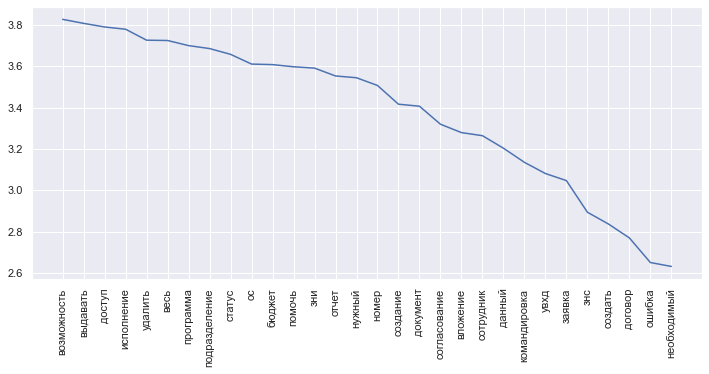

In [27]:
fig = plt.figure(figsize=(12, 5));
plt.plot(tfidf_features.tail(30)['words'].values, tfidf_features.tail(30)['idf'].values);
plt.xticks(rotation=90);

Как и BoW, TF-IDF можно использовать для n-грамм, а не только для отдельных слов. Создадим новый объект ```TfidfVectorizer```, который будет уметь работать как с отдельными словами, так и с комбинациями слов. Для бысрого обучения моделей ограничимся биграммами, однако использование триграмм и n-грамм может повысить качество моделей.

In [28]:
tfidf_ngrams = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf_ngrams = tfidf_ngrams.fit_transform(X_train)

Выведем названия слов и сочетаний слов, вошедших в словарь. Видим, что помимо отдельных слов появились биграммы:

In [29]:
tfidf_ngrams.get_feature_names_out()

array(['_операции', '_операции наличный', '_отражена', ..., 'ящик',
       'ящик никакой', 'ящик темпокасса'], dtype=object)

Также за счет добавления биграмм значительно увеличился словарь:

In [30]:
len(tfidf_ngrams.vocabulary_)

92812

Выведем 5 самых часто встречающихся слов в словаре, опираясь на значения из атрибута ```idf_```:

In [31]:
tfidf_ngrams_features = pd.DataFrame({
    'words': tfidf_ngrams.get_feature_names_out(),
    'idf': tfidf_ngrams.idf_
}).sort_values(by='idf', ascending=False)
tfidf_ngrams_features.head()

,words,idf
0,_операции,9.551691
57441,пополам,9.551691
57451,пополняться уважение,9.551691
57450,пополняться необходимый,9.551691
57448,пополнить корпоративный,9.551691


#### Обучение моделей 

Обучим модели на признаках, полученных с помощью ```TfidfVectorizer```.

In [32]:
results_tfidf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

Аналогичным образом обучим пайплайны для тех же моделей, но заменим шаг представления текста с BoW на TF-IDF.

In [33]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer()),  # tf-idf
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))  # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF', 'SVM', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.697196,0.69199,0.697196,0.687978


In [34]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer(ngram_range=(1, 2))),  # tf-idf с n-граммами
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))  # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF ngrams', 'SVM', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.697196,0.69199,0.697196,0.687978
TF-IDF ngrams + SVM,0.709747,0.708019,0.709747,0.696714


In [35]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer()),  # tf-idf
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF', 'LogReg', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.697196,0.69199,0.697196,0.687978
TF-IDF ngrams + SVM,0.709747,0.708019,0.709747,0.696714
TF-IDF + LogReg,0.653461,0.681033,0.653461,0.638425


In [36]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer(ngram_range=(1, 2))),   # tf-idf с n-граммами
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF ngrams', 'LogReg', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.697196,0.69199,0.697196,0.687978
TF-IDF ngrams + SVM,0.709747,0.708019,0.709747,0.696714
TF-IDF + LogReg,0.653461,0.681033,0.653461,0.638425
TF-IDF ngrams + LogReg,0.615415,0.673585,0.615415,0.591781


In [37]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer()),  # tf-idf
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF', 'RF', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.697196,0.69199,0.697196,0.687978
TF-IDF ngrams + SVM,0.709747,0.708019,0.709747,0.696714
TF-IDF + LogReg,0.653461,0.681033,0.653461,0.638425
TF-IDF ngrams + LogReg,0.615415,0.673585,0.615415,0.591781
TF-IDF + RF,0.668955,0.687662,0.668955,0.650588


In [38]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer(ngram_range=(1, 2))),   # tf-idf с n-граммами
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF ngrams', 'RF', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.697196,0.69199,0.697196,0.687978
TF-IDF ngrams + SVM,0.709747,0.708019,0.709747,0.696714
TF-IDF + LogReg,0.653461,0.681033,0.653461,0.638425
TF-IDF ngrams + LogReg,0.615415,0.673585,0.615415,0.591781
TF-IDF + RF,0.668955,0.687662,0.668955,0.650588
TF-IDF ngrams + RF,0.654246,0.67842,0.654246,0.63468


Проанализировав таблицу с результатами, видно, что лучшие результаты были получены для N-грамм с методом опорных векторов. Также можно заметить небольшое улучшение результатов относительно BoW.

### Co-occurrence matrix

Матрица встречаемости слов позволяет учесть контекст употребления слова. Первым шагом при построении такой матрицы является построение словаря слов в корпусе размерностью N. Как и в предыдущих подходах, размер векторного представления слова будет вектор размера N. 

Пусть в качестве контекста слова выступают 2 слова до и после целевого. Теперь для целевого слова отметим в векторе для каждого слова в словаре количество раз, когда они встретились вместе в одном контексте. Полученный вектор будет являться вектором встречаемости слов. Ту же операцию нужно будет проделать для всего словаря.

Построим матрицу встречаемости слов для наглядности для самого малочисленного класса в наборе данных. Так как размер словаря всего тренировочного датасета составляет около 8.5 тысяч слов, очевидно, что матрица встречаемости будет сильно разреженная и почти целиком состоит из нулей. Из-за особенностей представления данных, матрица встречаемости для всего тренировочного набора может не поместиться в оперативную память.

In [50]:
tokenized_data = df[df['class'] == '1-14']['cleaned'].apply(lambda x: x.split())
tokenized_data.head()

320     [сегодня, создание, согласование, знс, приходи...
332     [попытка, отправить, знс, согласование, систем...
640     [отправка, знс, согласование, появляться, запи...
2028    [знс, отправляться, согласование, выдаваться, ...
2164    [отправка, знс, согласование, выводиться, ошиб...
Name: cleaned, dtype: object

Построим словарь уникальных слов:

In [53]:
words = list(set(tokenized_data.values.sum()))
len(words)

377

Инициализируем пустую матрицу встречаемости слов и напишем функцию для ее заполнения.

In [54]:
co_occurrence_matrix = pd.DataFrame(
    np.zeros((len(words), len(words))),
    columns=words, 
    index=words
)
co_occurrence_matrix

,деятельность,сотрудник,подписант-обработчик,найти,спп-элемент,видеть,пытаться,отправить,бюджетный,измениться,...,приходить,пятый,оформлять,карточка,оплата,конкретный,работа,решить,недвижимость,мвз
деятельность,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
сотрудник,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
подписант-обработчик,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
найти,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
спп-элемент,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
конкретный,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
работа,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
решить,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
недвижимость,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
def build_context(tokens, matrix):
    for idx, token in enumerate(tokens):
        start = 0 if idx - 2 < 0 else idx - 2
        end = len(tokens) if idx + 2 > len(tokens) else idx + 3
        context = tokens[start:idx] + tokens[idx + 1:end]

        for word in context:
            matrix.loc[token, word] += 1

    return matrix

In [61]:
co_occurrence_matrix = build_context(tokenized_data.values.sum(), co_occurrence_matrix)

Получили матрицу встречаемости слов следующего вида:

In [62]:
co_occurrence_matrix

,деятельность,сотрудник,подписант-обработчик,найти,спп-элемент,видеть,пытаться,отправить,бюджетный,измениться,...,приходить,пятый,оформлять,карточка,оплата,конкретный,работа,решить,недвижимость,мвз
деятельность,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
сотрудник,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
подписант-обработчик,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
найти,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
спп-элемент,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
конкретный,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
работа,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
решить,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
недвижимость,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


Выведем 15 самых часто встречающихся в контексте слов для слова "знс":

In [64]:
co_occurrence_matrix.loc['знс'].sort_values(ascending=False).head(15)

согласование    57.0
отправить       21.0
отправка        16.0
ошибка          15.0
знс             14.0
создание        14.0
маршрут         12.0
создать         11.0
обработчик      11.0
согласовать      8.0
выходить         7.0
выдавать         7.0
отправляться     6.0
позиция          6.0
невозможный      5.0
Name: знс, dtype: float64

Матрицы встречаемости слов могут использоваться в различных задачах:
- классификация текстов
- тематическое моделирование
- рекомендательные системы
- анализ настроения и др.

# Задание

1. Разделите датасет, выбранный в прошлом задании, на обучающую и тестовую выборки.

2. Выделите признаки из корпуса текстов с помощью мешка слов. Обучите несколько моделей, оцените результат с помощью Accuracy, Precision, Recall, F1-score. Постройте биграммы и сравните результаты обучения с обычным мешком слов.

3. Выделите признаки из корпуса текстов с помощью TF-IDF. Обучите несколько моделей, оцените результат с помощью метрик. Постройте биграммы и сравните результаты обучения с обычным TF-IDF. 

4. Постройте матрицу встречаемости слов для вашего обучающего датасета.